# 🌍 Gridflow Subregion Geospatial Processing Workflow

This notebook outlines the workflow for generating and visualizing subregions based on geospatial renewable potential data (e.g., solar PV or wind) for selected countries. The goal is to segment each country's territory into spatial subregions using raster data and analyze them in relation to administrative boundaries. Notebook is designed by Jiajia Wang (Jessica) on 07/17/2025.

---

## 1. Setup and Configuration

- Import necessary libraries such as `geopandas`, `rioxarray`, `skimage`, `matplotlib`, and `pandas`.
- Define a `base_path` to avoid repeated hardcoding of file paths.
- Dynamically construct full paths using `os.path.join()` for better readability and cross-platform compatibility.

---

## 2. Load Country Data

- Define a list of countries of interest (e.g., `['ETH', 'SOM', 'KEN']`).
- For each country:
  - Load its national boundary shapefile.
  - Load corresponding solar or wind raster data.
  - Store all relevant paths and metadata in a centralized structure (`self.region_data`).

---

## 3. Subregion Creation

- Use the `RegionSegmentation` class to encapsulate all logic.
- The method `create_subregions(n, method)` performs:
  - Raster loading (`pv` or `wind` selected via the `method` argument).
  - Conversion to NumPy arrays and optional masking of invalid data.
  - Segmentation of raster into `n` subregions using `skimage.measure.label()` or similar connected-component analysis.
  - Output is a new raster where each pixel is assigned a subregion label.

---

## 4. Load Subregion Point Data

- A CSV file containing representative point locations for each generated subregion is loaded using:
  ```python
  location_file = os.path.join(base_path, "data", "generated_subregion_points.csv")
  df = pd.read_csv(location_file)

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install required packages
# Need to run this every time in the colab environment. In local IDE, it is uneccesary after first instalation
!pip install geopandas rasterio rioxarray rasterstats scikit-image matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 34.5 MB/s eta 0:00:00


In [ ]:
# Import Required Libraries
import glob
import os
import sys
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.mask import mask
from rasterio.io import MemoryFile
import rioxarray
from shapely.geometry import mapping, Point, box
import random
from datetime import datetime
import geopandas as gpd
from shapely.ops import unary_union
import warnings
warnings.filterwarnings('ignore')
import time

In [ ]:
# Define the base path
base_path = '/content/drive/MyDrive/gridflow-add-region-subregion-support'
data_path = os.path.join(base_path, 'data')
global_data_path = os.path.join(data_path, 'global')

# Define global data paths
GLOBAL_SHAPEFILE_PATH = os.path.join(global_data_path, 'world_bank_official_boundaries', 'WB_GAD_ADM0_complete.shp')
GLOBAL_PV_FILE = os.path.join(global_data_path, 'global_PVOUT.tif')
GLOBAL_WIND_FILE = os.path.join(global_data_path, 'power_density_cog_50m.tif')

In [ ]:
# Add the gridflow module to Python path
sys.path.append(base_path)
# Import the region class from model module
from gridflow.model import region
# Import other classes if needed
from gridflow.model import network, regiondata
# Import API data download from utils module
from gridflow.utils import get_renewable_data

In [13]:
def load_countries_of_interest(countries_list):
    """
    Load only the countries of interest from the global shapefile

    Parameters:
    -----------
    countries_list : list
        List of ISO_A3 country codes (e.g., ['ETH', 'SOM', 'KEN'])

    Returns:
    --------
    gpd.GeoDataFrame
        GeoDataFrame containing only the selected countries
    """
    print(f"Loading countries: {countries_list}")

    # Load the global shapefile
    global_gdf = gpd.read_file(GLOBAL_SHAPEFILE_PATH)

    # Filter for countries of interest
    countries_gdf = global_gdf[global_gdf['ISO_A3'].isin(countries_list)]

    if len(countries_gdf) != len(countries_list):
        found_countries = countries_gdf['ISO_A3'].tolist()
        missing = set(countries_list) - set(found_countries)
        print(f"Warning: Countries not found: {missing}")

    print(f"Loaded {len(countries_gdf)} countries")
    print(f"CRS: {countries_gdf.crs}")

    return countries_gdf

def get_raster_bounds_for_countries(countries_gdf, buffer_degrees=0.1):
    """
    Get the bounding box for all selected countries with a small buffer

    Parameters:
    -----------
    countries_gdf : gpd.GeoDataFrame
        GeoDataFrame with country boundaries
    buffer_degrees : float
        Buffer in degrees to add around the bounding box

    Returns:
    --------
    tuple
        (minx, miny, maxx, maxy) in EPSG:4326
    """
    # Ensure we're in EPSG:4326 for the bounds
    countries_4326 = countries_gdf.to_crs('EPSG:4326')

    # Get total bounds
    minx, miny, maxx, maxy = countries_4326.total_bounds

    # Add buffer (notes)
    minx -= buffer_degrees
    miny -= buffer_degrees
    maxx += buffer_degrees
    maxy += buffer_degrees

    print(f"Bounding box for raster loading: ({minx:.2f}, {miny:.2f}, {maxx:.2f}, {maxy:.2f})")

    return minx, miny, maxx, maxy

def load_partial_raster(raster_path, bounds, countries_gdf):
    """
    Load only the portion of a raster that covers the selected countries

    Parameters:
    -----------
    raster_path : str
        Path to the raster file
    bounds : tuple
        (minx, miny, maxx, maxy) bounding box
    countries_gdf : gpd.GeoDataFrame
        GeoDataFrame with country boundaries

    Returns:
    --------
    tuple
        (data_array, metadata, transform)
    """
    minx, miny, maxx, maxy = bounds

    with rasterio.open(raster_path) as src:
        # Create a bounding box polygon
        bbox = box(minx, miny, maxx, maxy)

        # Get the window for the bounding box
        window = rasterio.windows.from_bounds(
            minx, miny, maxx, maxy,
            transform=src.transform
        )

        # Read only the windowed portion
        data = src.read(1, window=window)

        # Get the transform for the window
        transform = rasterio.windows.transform(window, src.transform)

        # Update metadata
        meta = src.meta.copy()
        meta.update({
            'height': data.shape[0],
            'width': data.shape[1],
            'transform': transform
        })

        print(f"Loaded raster subset: {data.shape} (original full size would be {src.height}x{src.width})")

        return data, meta, transform

def crop_raster_to_country(raster_data, raster_meta, country_geom, output_path):
    """
    Crop a raster to a specific country boundary

    Parameters:
    -----------
    raster_data : numpy array
        Raster data
    raster_meta : dict
        Raster metadata
    country_geom : GeoDataFrame
        Country boundary
    output_path : str
        Path to save cropped raster
    """
    # Create a temporary in-memory raster
    with MemoryFile() as memfile:
        with memfile.open(**raster_meta) as src:
            src.write(raster_data, 1)

            # Ensure CRS match
            if src.crs != country_geom.crs:
                country_geom = country_geom.to_crs(src.crs)

            # Crop to country boundary
            out_image, out_transform = mask(
                src,
                [mapping(country_geom.geometry.iloc[0])],
                crop=True,
                nodata=src.nodata
            )

            # Update metadata
            out_meta = src.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform
            })

            # Write the cropped raster
            with rasterio.open(output_path, "w", **out_meta) as dest:
                dest.write(out_image)

    return output_path

def find_raster_files(base_path, pattern='*.tif'):
    """
    Find raster files in a directory

    Parameters:
    -----------
    base_path : str
        Directory to search
    pattern : str
        File pattern to match

    Returns:
    --------
    list
        List of raster file paths
    """
    search_pattern = os.path.join(base_path, '**', pattern)
    files = glob.glob(search_pattern, recursive=True)

    if not files:
        # Try without recursive search
        search_pattern = os.path.join(base_path, pattern)
        files = glob.glob(search_pattern)

    return files

def process_countries(countries_list, base_data_path, n_subregions=5):
    """
    Process multiple countries efficiently by loading rasters only once

    Parameters:
    -----------
    countries_list : list
        List of ISO_A3 country codes
    base_data_path : str
        Base path for data storage
    n_subregions : int
        Number of subregions to create per country

    Returns:
    --------
    dict
        Results dictionary with processed data for each country
    """
    # Load countries from global shapefile
    countries_gdf = load_countries_of_interest(countries_list)

    # Get bounding box for all countries
    bounds = get_raster_bounds_for_countries(countries_gdf)

    # Check if raster files exist
    if not os.path.exists(GLOBAL_PV_FILE):
        raise FileNotFoundError(f"PV raster not found at {GLOBAL_PV_FILE}")
    if not os.path.exists(GLOBAL_WIND_FILE):
        raise FileNotFoundError(f"Wind raster not found at {GLOBAL_WIND_FILE}")

    print(f"\nUsing PV raster: {os.path.basename(GLOBAL_PV_FILE)}")
    print(f"Using wind raster: {os.path.basename(GLOBAL_WIND_FILE)}")

    # Load partial rasters for the region of interest
    print("\nLoading PV raster subset...")
    pv_data, pv_meta, pv_transform = load_partial_raster(GLOBAL_PV_FILE, bounds, countries_gdf)

    print("\nLoading wind raster subset...")
    wind_data, wind_meta, wind_transform = load_partial_raster(GLOBAL_WIND_FILE, bounds, countries_gdf)

    # Process each country
    results = {}

    for idx, row in countries_gdf.iterrows():
        country_code = row['ISO_A3']
        country_name = row.get('NAME_EN', country_code)

        print(f"\n{'='*50}")
        print(f"Processing {country_name} ({country_code})")
        print(f"{'='*50}")

        # Create country-specific folders
        country_folder = os.path.join(base_data_path, f'{country_code}_processed')
        pv_folder = os.path.join(country_folder, 'pv')
        os.makedirs(pv_folder, exist_ok=True)

        # Get country geometry
        country_geom = countries_gdf[countries_gdf['ISO_A3'] == country_code]

        # Crop rasters to country boundary
        pv_cropped = os.path.join(pv_folder, 'pv.tif')
        wind_cropped = os.path.join(country_folder, 'wind.tif')

        print(f"  Cropping PV raster...")
        crop_raster_to_country(pv_data, pv_meta, country_geom, pv_cropped)

        print(f"  Cropping wind raster...")
        crop_raster_to_country(wind_data, wind_meta, country_geom, wind_cropped)

        # Create dummy population raster (as before)
        print(f"  Creating dummy population raster...")
        with rasterio.open(pv_cropped) as src:
            pop_data = np.ones_like(src.read(1)) * 1000
            pop_meta = src.meta.copy()

            pop_path = os.path.join(country_folder, 'pop.tif')
            with rasterio.open(pop_path, 'w', **pop_meta) as dst:
                dst.write(pop_data, 1)

        # Create dummy grid file
        grid_path = os.path.join(country_folder, 'grid.gpkg')
        empty_gdf = gpd.GeoDataFrame(geometry=[], crs=country_geom.crs)
        empty_gdf.to_file(grid_path, driver='GPKG')

        # IMPORTANT: Save the country boundary as well
        boundary_path = os.path.join(country_folder, 'boundary.gpkg')
        country_geom.to_file(boundary_path, driver='GPKG')

        # Initialize region object
        print(f"  Initializing region object...")
        country_region = region(country_code, country_folder)

        # Create subregions
        print(f"  Creating {n_subregions} subregions using PV potential...")
        subregions = country_region.create_subregions(n=n_subregions, method="pv")

        # Ensure subregions are clipped to country boundary
        print(f"  Clipping subregions to country boundary...")
        country_boundary = country_geom.geometry.iloc[0]
        subregions['geometry'] = subregions['geometry'].apply(
            lambda geom: geom.intersection(country_boundary) if geom.intersects(country_boundary) else None
        )
        # Remove any empty geometries
        subregions = subregions[subregions['geometry'].notna()]
        subregions = subregions[~subregions['geometry'].is_empty]

        # Display subregion statistics
        print(f"  Subregions created: {len(subregions)}")
        print(f"  Subregion columns: {list(subregions.columns)}")
        print(f"  Labels: {sorted(subregions['label'].unique())}")

        results[country_code] = {
            'region': country_region,
            'subregions': subregions,
            'country_name': country_name,
            'boundary': country_geom
        }

    return results

In [ ]:
# Post-process to merge subregions
def merge_smallest_subregions(subregions_gdf, target_n=3):
    """
    Merge the smallest subregions until we have exactly target_n subregions.
    """

    # Create a copy to avoid modifying the original
    gdf = subregions_gdf.copy()

    # Get unique labels and their counts
    current_labels = sorted(gdf['label'].unique())

    while len(current_labels) > target_n:
        print(f"Current number of subregions: {len(current_labels)}")

        # Calculate total area for each label
        label_areas = {}
        label_geometries = {}

        for label in current_labels:
            label_rows = gdf[gdf['label'] == label]
            # Union all geometries for this label
            combined_geom = unary_union(label_rows['geometry'].tolist())
            label_geometries[label] = combined_geom
            label_areas[label] = combined_geom.area

        # Find the smallest subregion
        smallest_label = min(label_areas, key=label_areas.get)
        print(f"Smallest subregion is {smallest_label} with area {label_areas[smallest_label]:.2f}")

        # Find the nearest neighbor to merge with
        smallest_geom = label_geometries[smallest_label]
        min_distance = float('inf')
        nearest_label = None

        for other_label in current_labels:
            if other_label != smallest_label:
                distance = smallest_geom.distance(label_geometries[other_label])
                if distance < min_distance:
                    min_distance = distance
                    nearest_label = other_label

        print(f"Merging subregion {smallest_label} into {nearest_label}")

        # Merge by changing the label
        gdf.loc[gdf['label'] == smallest_label, 'label'] = nearest_label

        # Update current labels
        current_labels = sorted(gdf['label'].unique())

    # Renumber labels to be sequential (1, 2, 3)
    old_to_new = {old: new for new, old in enumerate(sorted(current_labels), 1)}
    gdf['label'] = gdf['label'].map(old_to_new)

    # Dissolve geometries by label to create single polygons per subregion
    dissolved_gdf = gdf.dissolve(by='label', aggfunc='mean').reset_index()

    print(f"Final number of subregions: {len(dissolved_gdf)}")

    return dissolved_gdf

Loading countries: ['ETH', 'SOM', 'KEN']
Loaded 3 countries
CRS: EPSG:4326
Bounding box for raster loading: (32.90, -4.81, 51.52, 14.99)

Using PV raster: global_PVOUT.tif
Using wind raster: power_density_cog_50m.tif

Loading PV raster subset...


Loaded raster subset: (2376, 2234) (original full size would be 15000x43200)

Loading wind raster subset...
Loaded raster subset: (7920, 7447) (original full size would be 57600x144000)

Processing ETH (ETH)
  Cropping PV raster...
  Cropping wind raster...
  Creating dummy population raster...
  Initializing region object...
  Creating 3 subregions using PV potential...
  Clipping subregions to country boundary...
  Subregions created: 3
  Subregion columns: ['geometry', 'label', 'pv', 'wind', 'population']
  Labels: [np.float64(1.0), np.float64(2.0), np.float64(3.0)]

Processing KEN (KEN)
  Cropping PV raster...
  Cropping wind raster...
  Creating dummy population raster...
  Initializing region object...
  Creating 3 subregions using PV potential...
  Clipping subregions to country boundary...
  Subregions created: 3
  Subregion columns: ['geometry', 'label', 'pv', 'wind', 'population']
  Labels: [np.float64(1.0), np.float64(2.0), np.float64(3.0)]

Processing SOM (SOM)
  Cropping P

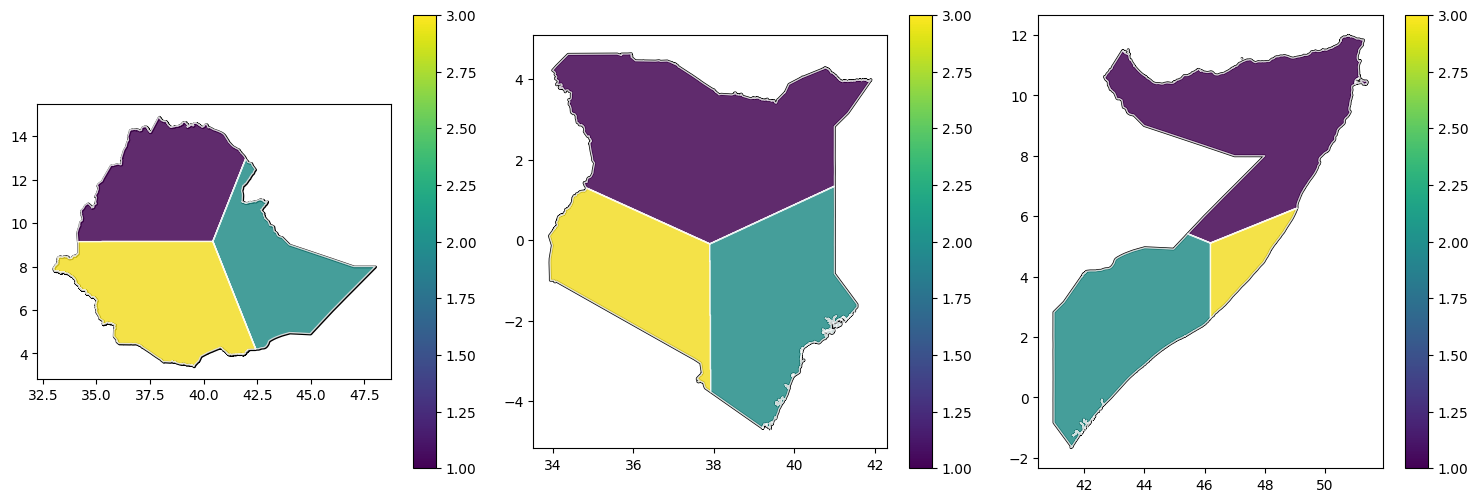

In [ ]:
# Define countries of interest
countries_of_interest = ['ETH', 'SOM', 'KEN']

# Process the countries
results = process_countries(
    countries_list=countries_of_interest,
    base_data_path=data_path,
    n_subregions=3
)

# Visualize results with country boundaries
fig, axes = plt.subplots(1, len(countries_of_interest), figsize=(15, 5))
if len(countries_of_interest) == 1:
    axes = [axes]

for idx, (country_code, data) in enumerate(results.items()):
    ax = axes[idx]

    # Get the country boundary
    country_boundary = data['boundary'].geometry.iloc[0]

    # Plot country boundary first (as background)
    data['boundary'].plot(ax=ax, color='lightgray', edgecolor='black', linewidth=2)

    # Plot subregions with transparency to see overlap
    data['subregions'].plot(ax=ax, column='label', cmap='viridis',
                            edgecolor='white', linewidth=1, alpha=0.8, legend=True)

plt.tight_layout()
plt.show()

In [ ]:
def points_generator_largest_polygon_only(results_dict, points_per_subregion=1, output_path=None, seed=42):
    """
    Generate random points from each subregion for each country.
    If a subregion has multiple polygons, only use the largest one.

    Parameters:
    -----------
    results_dict : dict
        Dictionary with country codes as keys and values containing:
        - 'region': region object
        - 'subregions': GeoDataFrame with subregion geometries
    points_per_subregion : int, default=1
        Number of random points to generate per subregion
    output_path : str, optional
        Path to save the output CSV file. If None, returns DataFrame only
    seed : int, default=42
        Random seed for reproducibility

    Returns:
    --------
    pd.DataFrame
        DataFrame with columns: country, subregion, lat, lon
    """
    # Set random seed for reproducibility
    random.seed(seed)
    np.random.seed(seed)

    # List to store all points
    all_points = []

    # Process each country
    for country_code, data in results_dict.items():
        subregions_gdf = data['subregions']

        # Get unique subregion labels
        unique_labels = sorted(subregions_gdf['label'].unique())

        for label in unique_labels:
            # Get all polygons for this subregion
            subregion_rows = subregions_gdf[subregions_gdf['label'] == label]

            # If multiple polygons, find the largest
            if len(subregion_rows) > 1:
                largest_idx = None
                largest_area = 0

                for idx, row in subregion_rows.iterrows():
                    area = row['geometry'].area
                    if area > largest_area:
                        largest_area = area
                        largest_idx = idx

                geometry = subregion_rows.loc[largest_idx, 'geometry']
                print(f"Note: {country_code} subregion {int(label)} has {len(subregion_rows)} polygons. Using largest one.")
            else:
                geometry = subregion_rows.iloc[0]['geometry']

            # Generate points within the geometry
            points = []
            minx, miny, maxx, maxy = geometry.bounds
            points_generated = 0
            max_attempts = points_per_subregion * 1000
            attempts = 0

            while points_generated < points_per_subregion and attempts < max_attempts:
                # Generate random coordinates
                random_x = random.uniform(minx, maxx)
                random_y = random.uniform(miny, maxy)
                random_point = Point(random_x, random_y)

                # Only keep if inside the actual geometry
                if geometry.contains(random_point):
                    points.append(random_point)
                    points_generated += 1

                attempts += 1

            # Method 2: If we couldn't generate enough points randomly,
            # use a more systematic approach
            if points_generated < points_per_subregion:
                # First, try the centroid if it's inside
                if geometry.contains(geometry.centroid):
                    points.append(geometry.centroid)
                    points_generated += 1

                # If still need more points, use representative point
                if points_generated < points_per_subregion:
                    points.append(geometry.representative_point())
                    points_generated += 1

                # If still need more, create a grid and sample
                if points_generated < points_per_subregion:
                    # Create a denser grid within bounds
                    x_points = np.linspace(minx, maxx, 20)
                    y_points = np.linspace(miny, maxy, 20)

                    # Shuffle to get random order
                    grid_points = [(x, y) for x in x_points for y in y_points]
                    random.shuffle(grid_points)

                    for x, y in grid_points:
                        if points_generated >= points_per_subregion:
                            break
                        test_point = Point(x, y)
                        if geometry.contains(test_point):
                            points.append(test_point)
                            points_generated += 1

            # Take only the required number of points
            selected_points = points[:points_per_subregion]

            # Convert each point to lat/lon
            for point in selected_points:
                # Transform the point to lat/lon
                temp_gdf = gpd.GeoDataFrame([1], geometry=[point], crs=subregions_gdf.crs)
                temp_gdf_4326 = temp_gdf.to_crs('EPSG:4326')

                lon = temp_gdf_4326.geometry.iloc[0].x
                lat = temp_gdf_4326.geometry.iloc[0].y

                # Add to the list
                all_points.append({
                    'country': country_code,
                    'subregion': int(label),
                    'lat': round(lat, 6),
                    'lon': round(lon, 6)
                })

            if len(selected_points) < points_per_subregion:
                print(f"Warning: Could only generate {len(selected_points)}/{points_per_subregion} points for {country_code} subregion {int(label)}")

    # Create DataFrame
    points_df = pd.DataFrame(all_points)

    # Sort by country and subregion for consistency
    points_df = points_df.sort_values(['country', 'subregion']).reset_index(drop=True)

    # Save to CSV if output path is provided
    if output_path:
        points_df.to_csv(output_path, index=False)
        print(f"Points saved to: {output_path}")

    return points_df

In [ ]:
# Generate 1 points per subregion by default
points_df = points_generator_largest_polygon_only(
    results_dict=results,
    points_per_subregion=1,
    output_path=os.path.join(data_path, 'generated_subregion_points.csv'),
    seed=42
)

# Display the results
print("\nGenerated points:")
print(points_df.head(20))
print(f"\nTotal points generated: {len(points_df)}")

# Show summary by country
print("\nPoints per country:")
print(points_df.groupby('country').size())

Points saved to: /content/drive/MyDrive/gridflow-add-region-subregion-support/data/generated_subregion_points.csv

Generated points:
  country  subregion       lat        lon
0     ETH          1  9.287882  39.123941
1     ETH          2  6.154461  42.512874
2     ETH          3  7.294030  39.944389
3     KEN          1  2.292045  35.722555
4     KEN          2 -3.504075  37.994682
5     KEN          3 -1.011601  36.517734
6     SOM          1  9.163348  44.597900
7     SOM          2  3.280579  45.186549
8     SOM          3  2.985513  46.464056

Total points generated: 9

Points per country:
country
ETH    3
KEN    3
SOM    3
dtype: int64


In [ ]:
# Read the subregion point data
location_file = os.path.join(base_path, "data", "generated_subregion_points.csv")
df = pd.read_csv(location_file)


# Create unique zone names by combining country and subregion
df['zone'] = df['country'] + '_' + df['subregion'].astype(str)

# Convert to dictionary {unique_zone_name: (lat, lon)}
locations = {}
for idx, row in df.iterrows():
    # Create a unique key for each point
    zone_name = f"{row['zone']}_p{idx}"
    locations[zone_name] = (row['lat'], row['lon'])

print(f"Total locations to fetch: {len(locations)}")

# STEP 5: Set the date range
start_date = "2024-01-01"
end_date = "2024-12-31"

# Split locations into smaller batches to avoid rate limiting
def fetch_data_in_batches(locations, power_type, start_date, end_date, batch_size=10):
    """Fetch data in smaller batches with delays to avoid rate limiting"""
    all_data = []
    all_requests = []

    # Convert locations to list for batching
    location_items = list(locations.items())
    total_batches = (len(location_items) + batch_size - 1) // batch_size

    for batch_num in range(total_batches):
        start_idx = batch_num * batch_size
        end_idx = min((batch_num + 1) * batch_size, len(location_items))
        batch_locations = dict(location_items[start_idx:end_idx])

        print(f"\nProcessing batch {batch_num + 1}/{total_batches} ({len(batch_locations)} locations)")

        try:
            # Fetch data for this batch
            batch_df, batch_requests = get_renewable_data(
                power_type=power_type,
                locations=batch_locations,
                start_date=start_date,
                end_date=end_date
            )

            if not batch_df.empty:
                all_data.append(batch_df)
            all_requests.extend(batch_requests)

            # Add delay between batches to avoid rate limiting
            if batch_num < total_batches - 1:
                print(f"Waiting 30 seconds before next batch to avoid rate limiting...")
                time.sleep(30)

        except Exception as e:
            print(f"Error in batch {batch_num + 1}: {e}")
            # Wait longer if we hit an error
            if batch_num < total_batches - 1:
                print(f"Waiting 60 seconds before retrying...")
                time.sleep(60)

    # Combine all data
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
    else:
        combined_df = pd.DataFrame()

    return combined_df, all_requests

# Fetch raw PV data in batches
print("\nFetching solar data...")
solar_df, solar_requests = fetch_data_in_batches(
    locations=locations,
    power_type="solar",
    start_date=start_date,
    end_date=end_date,
    batch_size=6
)

# Fetch raw Wind data in batches
print("\nFetching wind data...")
wind_df, wind_requests = fetch_data_in_batches(
    locations=locations,
    power_type="wind",
    start_date=start_date,
    end_date=end_date,
    batch_size=6
)

# Add zone information back to the dataframes
def extract_zone_from_location_name(location_name):
    # Remove the _pX suffix to get the actual zone (note)
    return '_'.join(location_name.split('_')[:-1])

# Create a mapping from coordinates back to zones
coord_to_zone = {}
for location_name, (lat, lon) in locations.items():
    zone = extract_zone_from_location_name(location_name)
    coord_to_zone[(round(lat, 6), round(lon, 6))] = zone

# Add zone column to solar and wind dataframes
if not solar_df.empty:
    solar_df['zone'] = solar_df.apply(
        lambda row: coord_to_zone.get((round(row['latitude'], 6), round(row['longitude'], 6)), 'UNKNOWN'),
        axis=1
    )

if not wind_df.empty:
    wind_df['zone'] = wind_df.apply(
        lambda row: coord_to_zone.get((round(row['latitude'], 6), round(row['longitude'], 6)), 'UNKNOWN'),
        axis=1
    )

# Verify we got all zones
print(f"\nSolar data shape: {solar_df.shape if not solar_df.empty else 'No data'}")
if not solar_df.empty:
    print(f"Unique zones in solar data: {solar_df['zone'].nunique()}")
    print(f"Zones: {sorted(solar_df['zone'].unique())}")

print(f"\nWind data shape: {wind_df.shape if not wind_df.empty else 'No data'}")
if not wind_df.empty:
    print(f"Unique zones in wind data: {wind_df['zone'].nunique()}")
    print(f"Zones: {sorted(wind_df['zone'].unique())}")

# STEP 9: Save outputs
solar_out = os.path.join(data_path, 'raw_pv_data_with_zones.csv')
wind_out = os.path.join(data_path, 'raw_wind_data_with_zones.csv')

if not solar_df.empty:
    # Reorder columns to put zone first
    solar_cols = ['zone'] + [col for col in solar_df.columns if col != 'zone']
    solar_df[solar_cols].to_csv(solar_out, index=False)
    print(f"\n✅ Solar data saved to: {solar_out}")
else:
    print("\n⚠️ No solar data to save")

if not wind_df.empty:
    # Reorder columns to put zone first
    wind_cols = ['zone'] + [col for col in wind_df.columns if col != 'zone']
    wind_df[wind_cols].to_csv(wind_out, index=False)
    print(f"✅ Wind data saved to: {wind_out}")
else:
    print("⚠️ No wind data to save")

# Report any missing zones
if not solar_df.empty and not wind_df.empty:
    expected_zones = set(df['zone'].unique())
    solar_zones = set(solar_df['zone'].unique()) - {'UNKNOWN'}
    wind_zones = set(wind_df['zone'].unique()) - {'UNKNOWN'}

    missing_solar = expected_zones - solar_zones
    missing_wind = expected_zones - wind_zones

    if missing_solar:
        print(f"\n⚠️ Missing zones in solar data: {sorted(missing_solar)}")
    if missing_wind:
        print(f"⚠️ Missing zones in wind data: {sorted(missing_wind)}")

Total locations to fetch: 9

Fetching solar data...

Processing batch 1/2 (6 locations)
Waiting for a minute to not hit the API rate limit...
Hit rate limit. Sleeping for 36.80 seconds.
Error in batch 1: 'int' object is not iterable
Waiting 60 seconds before retrying...

Processing batch 2/2 (3 locations)
Error in batch 2: 'int' object is not iterable

Fetching wind data...

Processing batch 1/2 (6 locations)
Waiting for a minute to not hit the API rate limit...
Hit rate limit. Sleeping for 42.91 seconds.
Error in batch 1: 'int' object is not iterable
Waiting 60 seconds before retrying...

Processing batch 2/2 (3 locations)
Error in batch 2: 'int' object is not iterable

Solar data shape: (79056, 6)
Unique zones in solar data: 9
Zones: ['ETH_1', 'ETH_2', 'ETH_3', 'KEN_1', 'KEN_2', 'KEN_3', 'SOM_1', 'SOM_2', 'SOM_3']

Wind data shape: (79056, 6)
Unique zones in wind data: 9
Zones: ['ETH_1', 'ETH_2', 'ETH_3', 'KEN_1', 'KEN_2', 'KEN_3', 'SOM_1', 'SOM_2', 'SOM_3']

✅ Solar data saved to: /

In [ ]:
# Process raw data and add zone labels in the required format for EPM
# Load the raw data
solar_df = pd.read_csv(solar_out)
wind_df = pd.read_csv(wind_out)

# Load the location mapping to get country and subregion info
location_df = pd.read_csv(location_file)

# Create a mapping from (lat, lon) to zone code
def create_zone_mapping(location_df):
    """Create mapping from coordinates to zone codes in format ISO3_X"""
    zone_mapping = {}
    for _, row in location_df.iterrows():
        # Round to 6 decimal places to match the data
        key = (round(row['lat'], 6), round(row['lon'], 6))
        zone_code = f"{row['country']}_{row['subregion']}"
        zone_mapping[key] = zone_code
    return zone_mapping

zone_mapping = create_zone_mapping(location_df)

# Function to process and reshape data to match the required format
def process_to_profile_format(df, zone_mapping, data_type='solar'):
    """
    Process renewable data to match the profile format
    Aggregates multiple points in the same zone by taking the mean
    """
    # Create a copy to avoid modifying original
    processed_df = df.copy()

    # Add zone column based on coordinates
    processed_df['zone'] = processed_df.apply(
        lambda row: zone_mapping.get(
            (round(row['latitude'], 6), round(row['longitude'], 6)),
            'UNKNOWN'
        ),
        axis=1
    )

    # Filter out unmapped zones
    processed_df = processed_df[processed_df['zone'] != 'UNKNOWN']

    # Convert local_time to datetime
    processed_df['local_time'] = pd.to_datetime(processed_df['local_time'])

    # Extract time components
    processed_df['month'] = processed_df['local_time'].dt.month
    processed_df['day'] = processed_df['local_time'].dt.day
    processed_df['hour'] = processed_df['local_time'].dt.hour

    # Add month string (m1, m2, ..., m12) and day string (d1, d2, ..., d31)
    processed_df['q'] = 'm' + processed_df['month'].astype(str)
    processed_df['d'] = 'd' + processed_df['day'].astype(str)

    # Rename the power column
    if data_type in processed_df.columns:
        processed_df['value'] = processed_df[data_type]

    # Print information about multiple points per zone
    points_per_zone = processed_df.groupby('zone')['latitude'].nunique()
    print(f"\nPoints per zone for {data_type}:")
    for zone, count in points_per_zone.items():
        print(f"  {zone}: {count} points")

    # Aggregate by zone, month, day, and hour (taking mean of multiple points)
    aggregated_df = processed_df.groupby(['zone', 'q', 'd', 'hour'])['value'].mean().reset_index()

    # Create pivot table to reshape data
    profile_data = []

    for zone in aggregated_df['zone'].unique():
        zone_data = aggregated_df[aggregated_df['zone'] == zone]

        # Group by month and day
        for (month_str, day_str), group in zone_data.groupby(['q', 'd']):
            row_data = {
                'zone': zone,
                'q': month_str,
                'd': day_str
            }

            # Add hourly values
            for hour in range(24):
                hour_data = group[group['hour'] == hour]
                if len(hour_data) > 0:
                    row_data[f't{hour+1}'] = hour_data['value'].iloc[0]
                else:
                    row_data[f't{hour+1}'] = np.nan

            profile_data.append(row_data)

    # Create DataFrame
    profile_df = pd.DataFrame(profile_data)

    # Sort by zone, month, and day
    profile_df['month_num'] = profile_df['q'].str.extract('(\d+)').astype(int)
    profile_df['day_num'] = profile_df['d'].str.extract('(\d+)').astype(int)
    profile_df = profile_df.sort_values(['zone', 'month_num', 'day_num'])
    profile_df = profile_df.drop(columns=['month_num', 'day_num'])

    # Ensure all columns are in the right order
    column_order = ['zone', 'q', 'd'] + [f't{i}' for i in range(1, 25)]
    profile_df = profile_df[column_order]

    return profile_df

# Process both datasets
print("Processing solar data...")
solar_profile = process_to_profile_format(solar_df, zone_mapping, 'solar')

print("\nProcessing wind data...")
wind_profile = process_to_profile_format(wind_df, zone_mapping, 'wind')

# Display information about the processed data
print(f"\nSolar profile shape: {solar_profile.shape}")
print(f"Wind profile shape: {wind_profile.shape}")
print(f"\nUnique zones in solar: {sorted(solar_profile['zone'].unique())}")
print(f"Unique zones in wind: {sorted(wind_profile['zone'].unique())}")

# Show sample of the data
print("\nSample of solar profile data:")
print(solar_profile.head(10))

print("\nSample of wind profile data:")
print(wind_profile.head(10))

# Check data completeness
print("\nData completeness check:")
for zone in solar_profile['zone'].unique():
    zone_data = solar_profile[solar_profile['zone'] == zone]
    print(f"Zone {zone}: {len(zone_data)} days of data")

# Save the profiles
solar_profile_out = os.path.join(data_path, 'solar_profile.csv')
wind_profile_out = os.path.join(data_path, 'wind_profile.csv')

solar_profile.to_csv(solar_profile_out, index=False)
wind_profile.to_csv(wind_profile_out, index=False)

print(f"\n✅ Profile data saved to:")
print(f"  - Solar: {solar_profile_out}")
print(f"  - Wind: {wind_profile_out}")
print("\n✅ Processing complete with aggregation!")

Processing solar data...

Points per zone for solar:
  ETH_1: 1 points
  ETH_2: 1 points
  ETH_3: 1 points
  KEN_1: 1 points
  KEN_2: 1 points
  KEN_3: 1 points
  SOM_1: 1 points
  SOM_2: 1 points
  SOM_3: 1 points

Processing wind data...

Points per zone for wind:
  ETH_1: 1 points
  ETH_2: 1 points
  ETH_3: 1 points
  KEN_1: 1 points
  KEN_2: 1 points
  KEN_3: 1 points
  SOM_1: 1 points
  SOM_2: 1 points
  SOM_3: 1 points

Solar profile shape: (3294, 27)
Wind profile shape: (3294, 27)

Unique zones in solar: ['ETH_1', 'ETH_2', 'ETH_3', 'KEN_1', 'KEN_2', 'KEN_3', 'SOM_1', 'SOM_2', 'SOM_3']
Unique zones in wind: ['ETH_1', 'ETH_2', 'ETH_3', 'KEN_1', 'KEN_2', 'KEN_3', 'SOM_1', 'SOM_2', 'SOM_3']

Sample of solar profile data:
     zone   q    d   t1   t2   t3   t4   t5   t6     t7  ...    t15    t16  \
0   ETH_1  m1   d1  0.0  0.0  0.0  0.0  0.0  0.0  0.001  ...  0.608  0.432   
11  ETH_1  m1   d2  0.0  0.0  0.0  0.0  0.0  0.0  0.001  ...  0.673  0.541   
22  ETH_1  m1   d3  0.0  0.0  0.